In [1]:
from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt
import pickle

/home/anna-ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/anna-ubuntu/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/anna-ubuntu/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:


dp_mix_stan = """
data
{
    int I; // number of areal locations
    int T; // number of time steps
    int P; // number of covariates
    int H; // truncation of stick breaking construction dp
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    matrix[I,I] W_raw; // proximity matrix
      
    // hyperpar vector of regressors
    vector[P+1]     mu_0; 
    matrix[P+1,P+1] Sigma_0;
    
    // w_1
    vector[I] mu_w_1;
    
    // alpha
    real a_alpha;
    real b_alpha;
    
    // tau^2
    real a_tau2;
    real b_tau2;
    
    // sigma^2
    real a_sigma2;
    real b_sigma2;
    
    // rho
    real alpha_rho;
    real beta_rho;
    
    //xis
    real a_xi;
    real b_xi;
}

transformed data
{
    vector[T] ones_T;
    for (t in 1:T)
        ones_T[t] = 1;
    
    matrix[T,T] eye_T;
    eye_T = diag_matrix(ones_T);
 
    vector[I] ones_I;
    for (i in 1:I)
        ones_I[i] = 1;
    
    matrix[I,I] eye_I;
    eye_I = diag_matrix(ones_I);
        
    matrix[I,I] W;
    W = diag_matrix(W_raw*ones_I) - W_raw;
}

parameters
{
    real<lower=0> alpha;
    real<lower=0> sigma2;
    real<lower=0> tau2;
    real<lower=0,upper=1> rho;
    
    
    // autoregressive coefficients still to reparametrize
    vector<lower=0,upper=1>[I]    xis_constructors;
    
    // random effects
    matrix[T,I]                ws;
    
    // betas for the mixture of the dirichlet process
    matrix[P+1,H]              betas; 
    
    // for the construction of the dirichlet process
    vector<lower=0,upper=1>[H-1] vs;
}

transformed parameters
{   // weights stick breaking construction
    simplex[H] omegas; 
    
    // sbc stuff
    vector[H-1] cumprod_one_mv;    
    cumprod_one_mv = exp(cumulative_sum(log1m(vs)));
    
    omegas[1] = vs[1];
    omegas[2:(H-1)] = vs[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    omegas[H] = cumprod_one_mv[H-1];

}

model
{
    alpha  ~ gamma(a_alpha,b_alpha);
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    rho    ~ beta(alpha_rho,beta_rho);
    vs     ~ beta(1,alpha);
    vector[I] xis;
    for (i in 1:I){
        xis_constructors[i] ~ beta(a_xi,b_xi);
        xis[i]=2*xis_constructors[i]-1;
     }   
     
    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    ws[1,1:I] ~ multi_normal(mu_w_1, tau2*inv_Q);
    
    for (t in 2:T)
        ws[t,1:I] ~ multi_normal(ws[t-1,1:I]*diag_matrix(xis), tau2*inv_Q);
    
    for (h in 1:H)
        betas[1:P+1,h] ~ multi_normal(mu_0, Sigma_0);
        
    for (i in 1:I) {
        vector[H] log_probs;
        
        for (h in 1:H) 
            log_probs[h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h] + ws[1:T,i], sigma2*eye_T);
        
        target += log_sum_exp(log_probs);
    }
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h]  + ws[1:T,i]  , sigma2*eye_T);
    
    }
}

generated quantities 
{   
    // vector of cluster allocations
    vector[I] s;
    
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h]  + ws[1:T,i]  , sigma2*eye_T);
    
    }
    for (i in 1:I)
        s[i] = categorical_rng(softmax(log_probs[i,1:H]'));

    
}
"""

stan_file = "bayesian.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dp_mix = CmdStanModel(stan_file=stan_file)

16:53:21 - cmdstanpy - INFO - compiling stan file /home/anna-ubuntu/bayesian-project/bayesian.stan to exe file /home/anna-ubuntu/bayesian-project/bayesian
16:55:56 - cmdstanpy - INFO - compiled model executable: /home/anna-ubuntu/bayesian-project/bayesian


[[1. 0. 1.]
 [0. 1. 0.]
 [1. 0. 1.]]


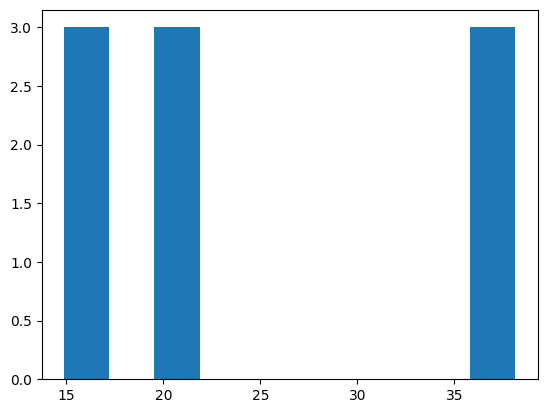

In [3]:
I = 110
T = 10
P = 3
means = np.array([-5, 0, 5]) #vector of possible mean 
true_beta=np.array([[+5, +10 ,-3],[5, +10, +3],[12 ,-4 ,0]])
#betas[s,p]
y = np.zeros(I*T)
true_clus_allocs = np.zeros(I) #cluster of each areal allocation 
X = np.ones((I*T,P+1)) # in this way the first column is made by one
for i in range(I*T):
   X[i,1:] = np.random.normal(loc=1,size= P) #the other P covariates are choosen randomly
for i in range(1,I+1): #for each areal location 
    true_clus = np.random.choice(np.arange(3), size=1) #choose a cluster randomly between (1,2,3)
    true_clus_allocs[i-1] = true_clus #save the cluster choosen
    loc=means[true_clus]+np.sum(true_beta[true_clus,:]*X[i,1:])
    y[T*(i-1):T*i] = np.random.normal(loc=loc,size= T) #sample for all the time from the cluster choosen
    # this are the data related to areal i for all time until T
plt.hist(y)



mu_0 = np.zeros(P+1) #as in the paper
mu_w_1 = np.zeros(I) #as in the paper

W_raw = np.eye(I) #proximity matrix, ones in the diagonal, symm, just made by 1 or 0
for i in range(I):
    for j in range(i):
        W_raw[i,j] = np.random.binomial(size=1, n=1, p= 0.5) #choosen rand from a bernoulli
        W_raw[j,i] = W_raw[i,j] #it has to be symm
print(W_raw)

Sigma_0 = np.eye(P+1) #covariance matrix


data = {
    "I": I,
    "T": T,
    "P": P,
    "H": 10,
    "y": y,
    "X": X,
    "W_raw": W_raw,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "alpha_rho": 5,
    "beta_rho": 1,
    "a_xi": 1,
    "b_xi": 1
}

In [4]:
true_clus_allocs

array([1., 1., 2.])

In [5]:
fit = dp_mix.sample(data
#                     , show_console = True
#                    , chains=4
#                     , adapt_delta=0.9
#                    , step_size = 1.5
#                    , max_treedepth = 100
                   )

16:55:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                         | 00:00 Status
chain 2 |                                                         | 00:00 Status

chain 3 |                                                         | 00:00 Status


chain 4 |                                                         | 00:00 Status
chain 2 |██▌                                                      | 00:00 Status

chain 3 |██▌                                                      | 00:00 Status


chain 1 |██▏                     | 00:02 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 2 |██▏                     | 00:02 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 4 |██▏                     | 00:03 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 3 |██▏                     | 00:04 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 4 |███▎                    | 00:05 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |████▎                   | 00:07 


16:57:06 - cmdstanpy - INFO - CmdStan done processing.
16:57:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 126, column 12 to column 147)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 126, column 12 to column 147)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 126, column 12 to column 147)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 100, column 4 to column 36)
	Exception: multi_normal_lpdf: Covariance matr

16:57:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 40 divergent transitions (4.0%)
	Chain 2 had 128 divergent transitions (12.8%)
	Chain 3 had 72 divergent transitions (7.2%)
	Chain 4 had 47 divergent transitions (4.7%)
	Use function "diagnose()" to see further information.


In [8]:

with open("mcmc_model_fit.pkl", "wb") as f:
    pickle.dump({'model' : dp_mix, 'fit' : fit}, f, protocol=-1)
    # or with a list
    pickle.dump([dp_mix, fit], f, protocol=-1)

/home/anna-ubuntu/.local/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (50), generating only 20 plots
  warnings.warn(


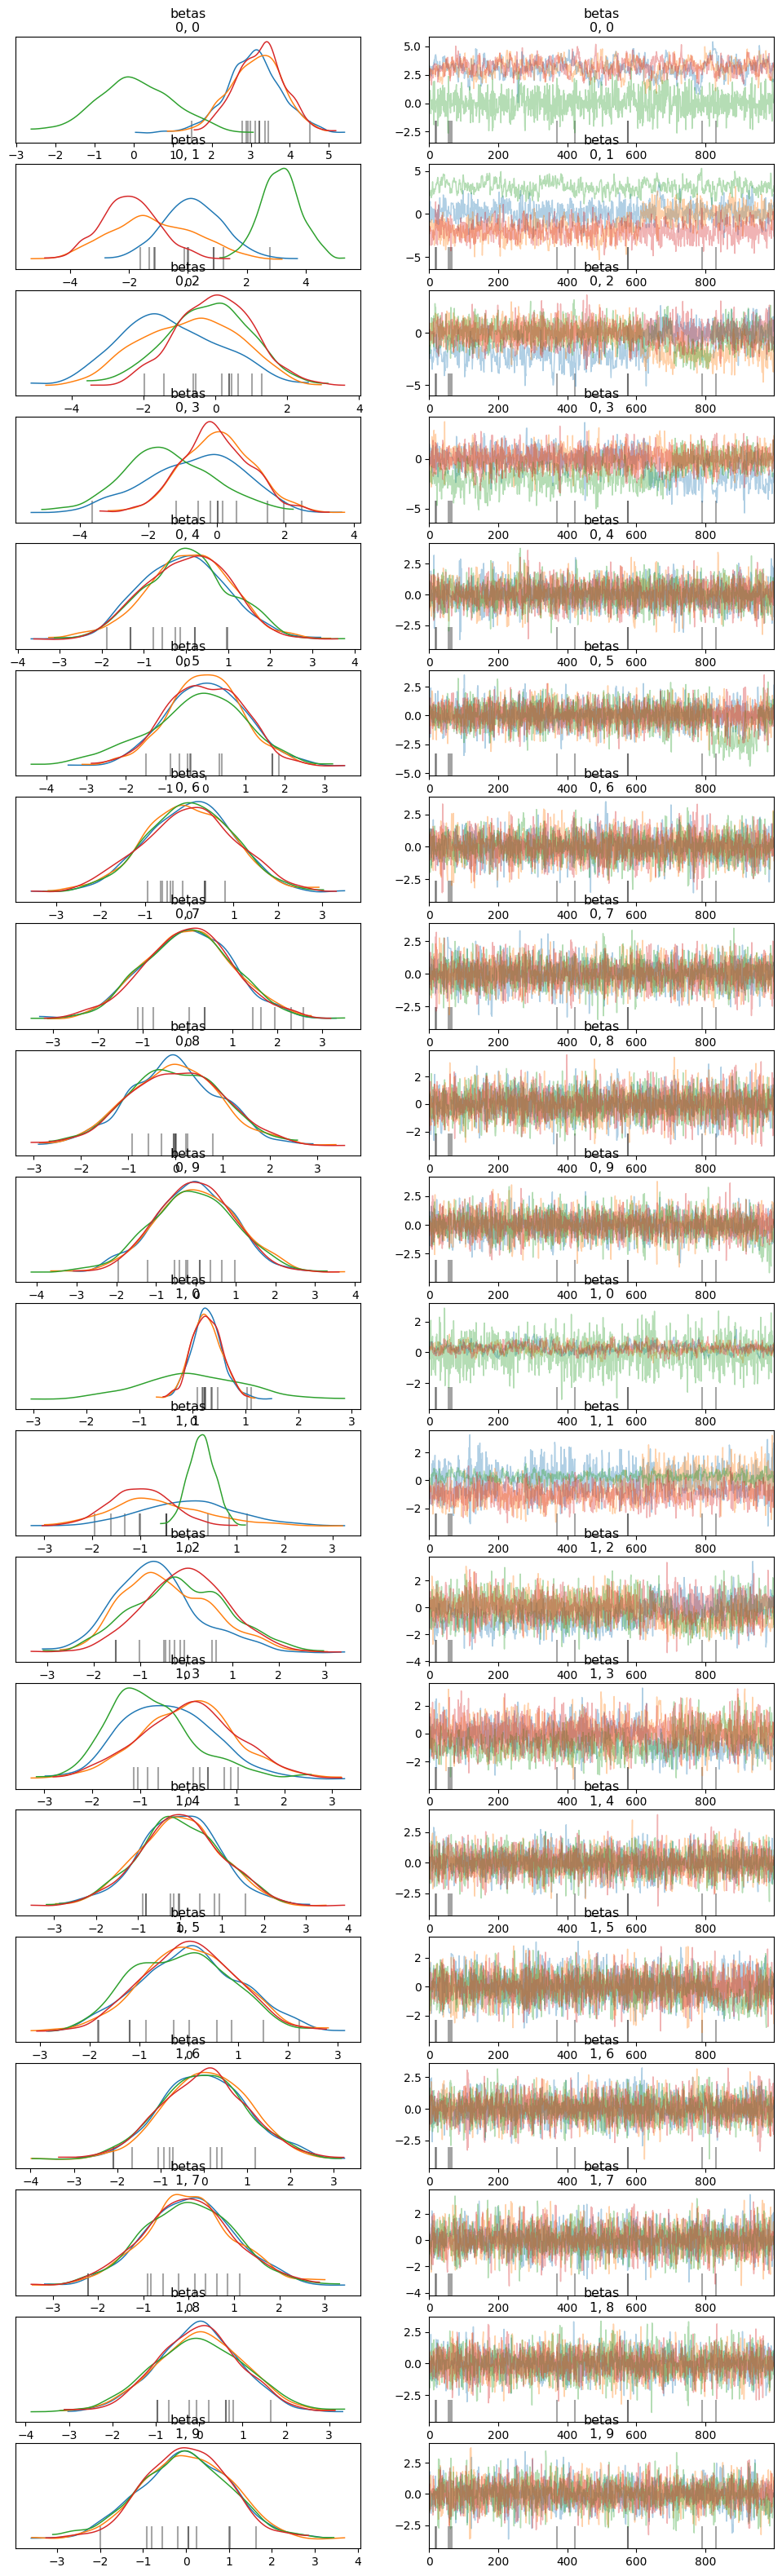

In [20]:
fit_az = az.from_cmdstanpy(fit)
az.plot_trace(fit, var_names=["betas"], compact=False)
plt.show()

In [13]:
fit.summary()

Mean      MCSE      StdDev          5%         50%  \
lp__            -277.270000  1.024710   15.509900 -304.084000 -276.299000   
alpha              1.372370  0.070121    0.819308    0.330700    1.203890   
sigma2             1.024540  0.050376    0.911464    0.336157    0.781632   
tau2             165.469000  1.130010   41.474000  109.125000  159.625000   
rho                0.392366  0.002369    0.128399    0.196382    0.383405   
...                     ...       ...         ...         ...         ...   
log_probs[6,6]  -136.895000  6.988640  163.246000 -463.792000  -77.409000   
log_probs[6,7]  -136.880000  6.433740  166.361000 -445.827000  -78.565900   
log_probs[6,8]  -135.831000  7.006660  162.932000 -416.167000  -81.543200   
log_probs[6,9]  -139.434000  7.268120  161.817000 -455.961000  -84.211000   
log_probs[6,10] -137.821000  8.466290  165.929000 -440.873000  -79.529600   

                        95%     N_Eff   N_Eff/s     R_hat  
lp__            -253.539000   229.095  0.244428  1.029180  
alpha              2.944070   136.522  0.145659  1.038880  
sigma2             2.347710   327.359  0.349268  1.019790  
tau2             240.866000  1347.070  1.437230  1.003380  
rho                0.617417  2938.150  3.134790  0.999822  
...                     ...       ...       ...       ...  
log_probs[6,6]   -17.892800   545.635  0.582152  1.015620  
log_probs[6,7]   -19.871000   668.614  0.713362  1.016990  
log_probs[6,8]   -22.717800   540.744  0.576935  1.021750  
log_probs[6,9]   -24.161000   495.681  0.528855  1.024790  
log_probs[6,10]  -20.958600   384.114  0.409822  1.023140  

[197 rows x 9 columns]

In [21]:
#Extimate pi[i,j] to compute Binder loss
#Likely not the most clever way to compute the matrix

n_chains=4
n_iteration_per_chain=1000
Binder_matrix= np.zeros((I,I))
for n in range(n_chains):
    for m in range(n_iteration_per_chain):
        for i in range(I):
            for j in range(i):
                if(i!=j and fit_az.posterior.s.values[n,m,i]==fit_az.posterior.s.values[n,m,j]):
                    Binder_matrix[i,j]+=1
                
Binder_matrix= Binder_matrix/(n_chains*n_iteration_per_chain)



In [22]:
#define Binder Loss

#Commented I added a penalty for a large number of clusters
#With penalty_n_clus=0 standard binder loss

def binder_function(binder_alloc):
    loss=0
    #penalty_n_clus=1
    #loss=penalty_n_clus*np.unique(binder_alloc).size
    
    for i in range(I):
        for j in range(i):
            
            if(binder_alloc[i]==binder_alloc[j]):
                    loss+=(1-Binder_matrix[i,j])**2
            
            else:
                loss+=(Binder_matrix[i,j])**2
            
    return loss

    

In [103]:
#Minimize Binder loss
# doesn't work with I big enough
#This solutions test every possibility and permutation
#it is likely to give a memory error

#import scipy
#max_n_clus=5
#ranges=[(0,max_n_clus-1)]*I
#scipy.optimize.brute(binder_function, ranges,  Ns=max_n_clus)

In [23]:
#Minimize Binder Loss evaluating the loss only 
#in the solutions found by stan model
#Not completly correct but should be a good doable approximation
n_chains=4
iteration_per_chain=1000
min_loss=10000
s_fixed=np.zeros(I)
for n in range(n_chains):
    for m in range(iteration_per_chain):
        loss=binder_function(fit_az.posterior.s.values[n,m])
        if(loss<min_loss):
            s_fixed=fit_az.posterior.s.values[n,m]

print('S_fixed')
print(s_fixed)

        
        

S_fixed
[1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1.]


In [24]:
print('True clusters')
print(true_clus_allocs)

True clusters
[0. 2. 0. 0. 0. 2. 2. 0. 1. 2. 2. 0. 0. 2. 2.]


In [163]:
# Fixed clustering s to study betas depending on clusters
beta_clus_stan = """
data
{
    int<lower=1> I; // number of areal locations
    int<lower=1> T; // number of time steps
    int<lower=1> P; // number of covariates
    int<lower=1> H; // number of possible clusters
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    matrix[I,I] W_raw; // proximity matrix
      
    // hyperpar vector of regressors
    vector[P+1]     mu_0; 
    matrix[P+1,P+1] Sigma_0;
    
    // w_1
    vector[I] mu_w_1;
    
    // alpha
    real<lower=0> a_alpha;
    real<lower=0> b_alpha;
    
    // tau^2
    real<lower=0> a_tau2;
    real<lower=0> b_tau2;
    
    // sigma^2
    real<lower=0> a_sigma2;
    real<lower=0> b_sigma2;
    
    // rho
    real<lower=0> alpha_rho;
    real<lower=0> beta_rho;
    
    //xis
    real<lower=0> a_xi;
    real<lower=0> b_xi;
    
    int s[I];
}

transformed data
{
    vector[T] ones_T;
    for (t in 1:T)
        ones_T[t] = 1;
    
    matrix[T,T] eye_T;
    eye_T = diag_matrix(ones_T);
 
    vector[I] ones_I;
    for (i in 1:I)
        ones_I[i] = 1;
    
    matrix[I,I] eye_I;
    eye_I = diag_matrix(ones_I);
        
    matrix[I,I] W;
    W = diag_matrix(W_raw*ones_I) - W_raw;
    
    
}

parameters
{
    real<lower=0> sigma2;
    real<lower=0> tau2;
    real<lower=0,upper=1> rho;
    
    
    // autoregressive coefficients still to reparametrize
    vector<lower=0,upper=1>[I]    xis_constructors;
    
    // random effects
    matrix[T,I]                ws;
    
   //Betas depend on clusters
    matrix[P+1,H]              betas_clus; 
    
    
}


model
{
    
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    rho    ~ beta(alpha_rho,beta_rho);
    
    
    xis_constructors ~ beta(a_xi,b_xi);
    vector[I] xis;
    xis = 2 * xis_constructors - 1; 
    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    ws[1,1:I] ~ multi_normal(mu_w_1, tau2*inv_Q);
    
    for (t in 2:T)
        ws[t,1:I] ~ multi_normal(ws[t-1,1:I]*diag_matrix(xis), tau2*inv_Q);
    
    for(h in 1:H)
    {
        betas_clus[1:P+1,h] ~ multi_normal(mu_0, Sigma_0);
    }
    for (i in 1:I){
        int clus_i=s[i]+1;
        
        y[T*(i-1)+1:i*T] ~ multi_normal(X[T*(i-1)+1:i*T, 1:P+1]*betas_clus[1:P+1,clus_i] + ws[1:T,i], sigma2*eye_T);
    }    
}

"""

stan_file = "beta_clus.stan"

with open(stan_file, "w") as fp:
    fp.write(beta_clus_stan)
    
beta_clus = CmdStanModel(stan_file=stan_file)

13:54:32 - cmdstanpy - INFO - compiling stan file /home/anna-ubuntu/bayesian-project/beta_clus.stan to exe file /home/anna-ubuntu/bayesian-project/beta_clus
13:56:03 - cmdstanpy - INFO - compiled model executable: /home/anna-ubuntu/bayesian-project/beta_clus
13:56:03 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
13:56:03 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/anna-ubuntu/bayesian-project/beta_clus.hpp /home/anna-ubuntu/bayesian-project/beta_clus.stan
Warning in '/home/anna-ubuntu/bayesian-project/beta_clus.stan', line 42, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/t

In [164]:
s= s_fixed.astype(int)

data_clus = {
    "I": I,
    "T": T,
    "P": P,
    "H": H,
    "y": y,
    "X": X,
    "W_raw": W_raw,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "alpha_rho": 5,
    "beta_rho": 1,
    "a_xi": 1,
    "b_xi": 1,
    "s":s
}


In [165]:
fit_clus = beta_clus.sample(data_clus
#                     , show_console = True
#                    , chains=4
#                     , adapt_delta=0.9
#                    , step_size = 1.5
#                    , max_treedepth = 100
                   )

13:56:03 - cmdstanpy - INFO - CmdStan start processing




chain 1 |                                                        | 00:00 Status




chain 2 |                                                        | 00:00 Status





chain 3 |                                                        | 00:00 Status






chain 4 |                                                        | 00:00 Status



chain 1 |██▌                                                     | 00:00 Status





chain 3 |██▌                                                     | 00:00 Status




chain 2 |██▌                                                     | 00:00 Status






chain 4 |██▌                                                     | 00:00 Status




chain 2 |██                     | 00:42 Iteration:    1 / 2000 [  0%]  (Warmup)






chain 4 |██                     | 00:44 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |██                     | 00:46 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 3 |█


14:03:02 - cmdstanpy - INFO - CmdStan done processing.
14:03:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,4] = 7.26839e+07, but Covariance matrix[4,1] = 7.26839e+07 (in '/home/anna-ubuntu/bayesian-project/beta_clus.stan', line 101, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,7] = 9.82788e+09, but Covariance matrix[7,1] = 9.82788e+09 (in '/home/anna-ubuntu/bayesian-project/beta_clus.stan', line 101, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in '/home/anna-ubuntu/bayesian-project/beta_clus.stan', line 101, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,14] = 3.82177e+27, but Covariance matrix[14,1] = 3.82177e+27 (in '/home/anna-ubuntu/bayesian-proje

/home/anna-ubuntu/.local/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (40), generating only 20 plots
  warnings.warn(


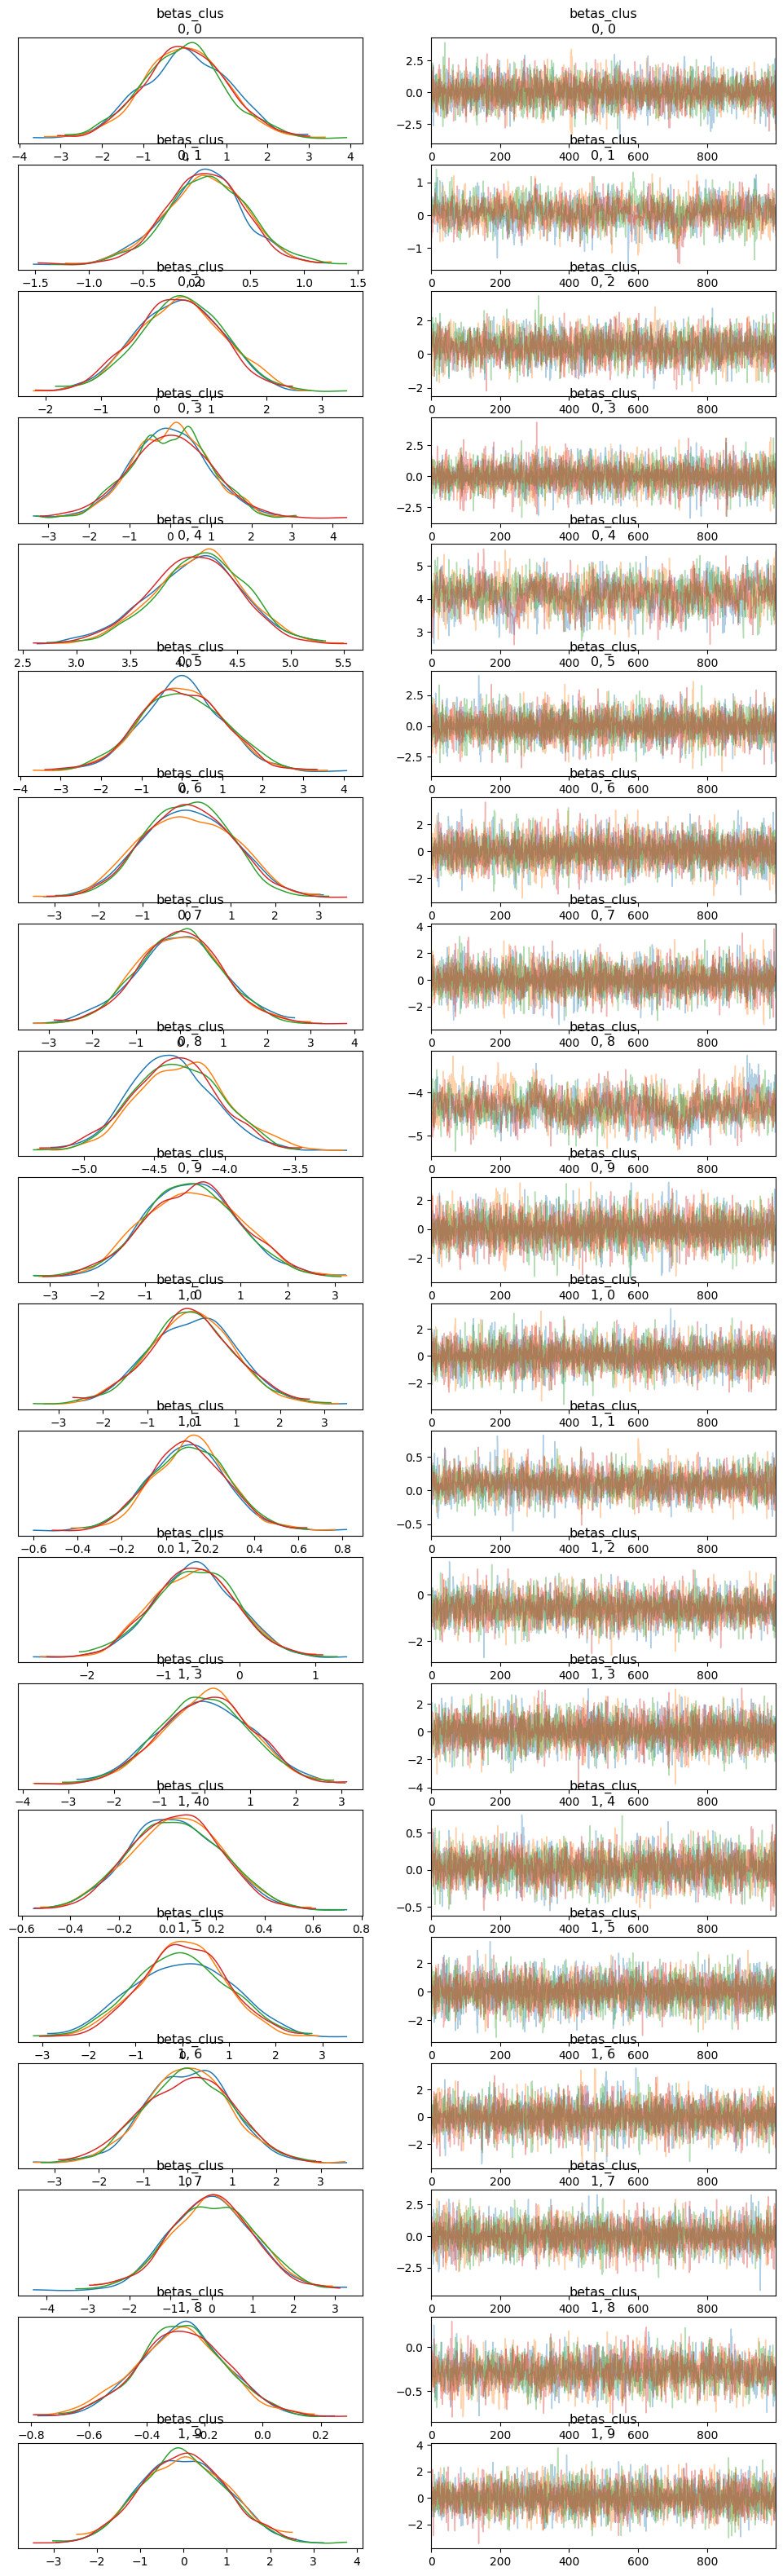

In [166]:
#betas[p,h] plot the betas specific to the clusters
fit_clus_az = az.from_cmdstanpy(fit_clus)
az.plot_trace(fit_clus, var_names=["betas_clus"], compact=False)
plt.show()


array([[<AxesSubplot: title={'center': 'betas_clus\n0, 0'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 1'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 2'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 3'}>],
       [<AxesSubplot: title={'center': 'betas_clus\n0, 4'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 5'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 6'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 7'}>],
       [<AxesSubplot: title={'center': 'betas_clus\n0, 8'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 9'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 0'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 1'}>],
       [<AxesSubplot: title={'center': 'betas_clus\n1, 2'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 3'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 4'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 5'}>],
       [<AxesSubplot

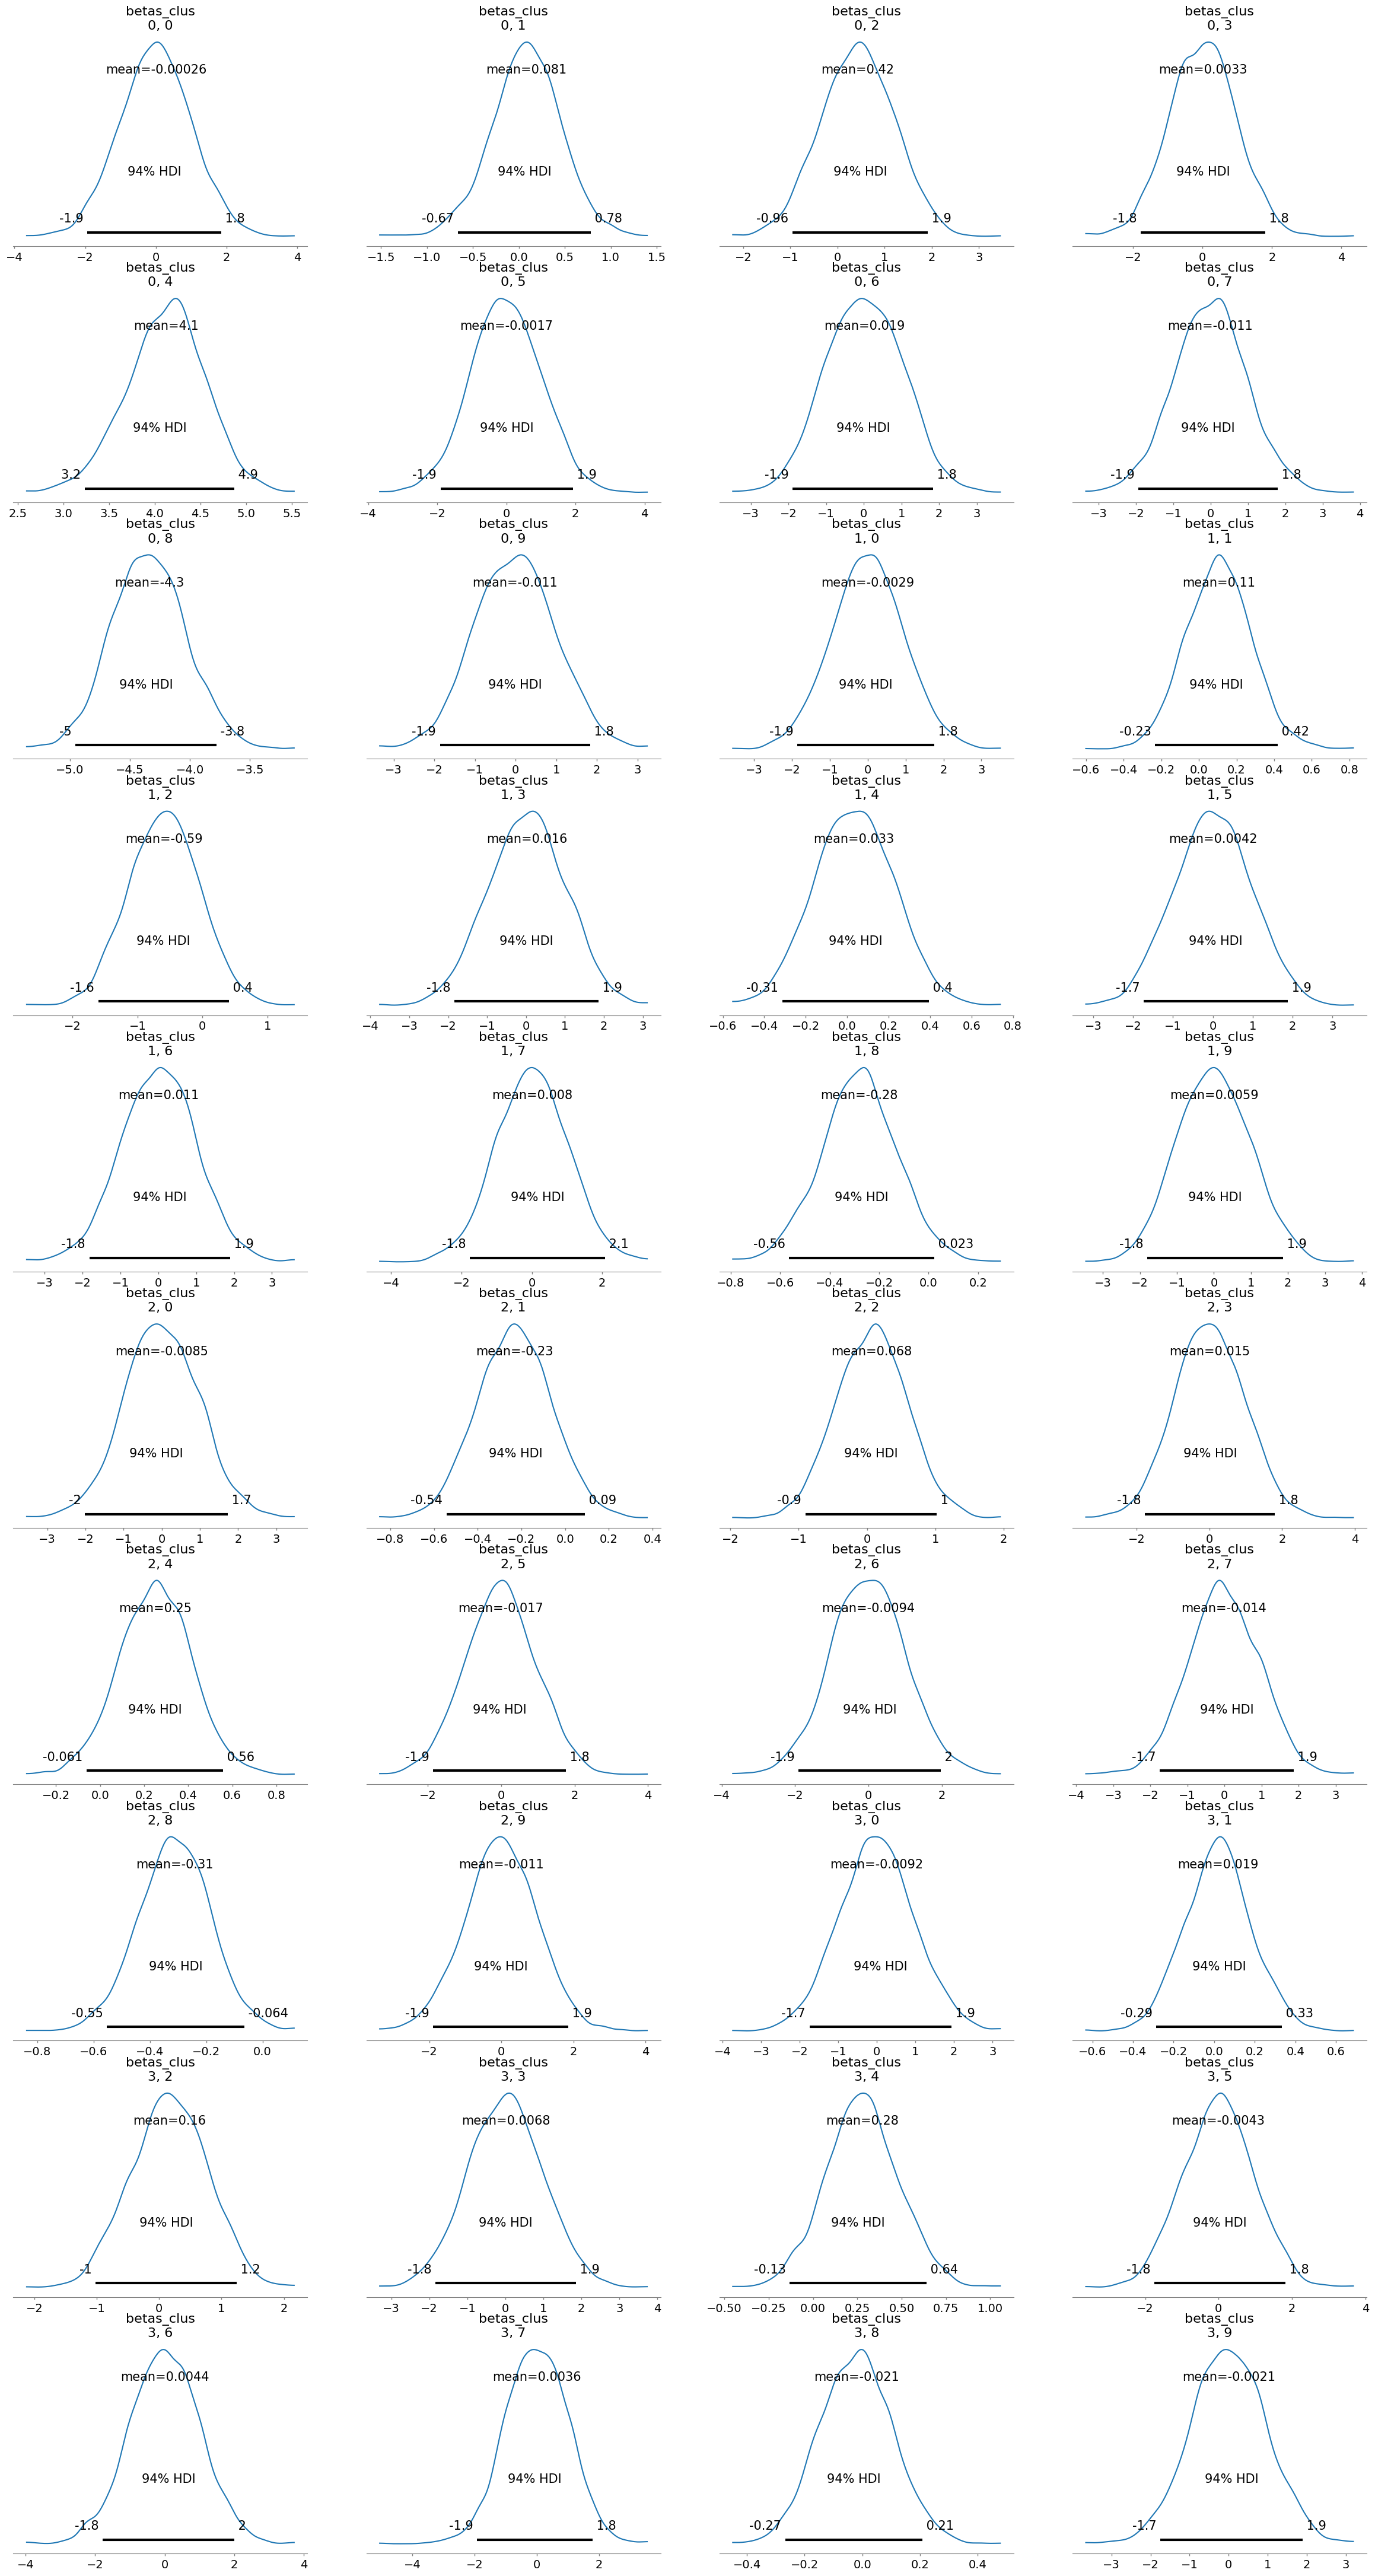

In [167]:
az.plot_posterior(fit_clus_az, var_names='betas_clus')

<AxesSubplot: >

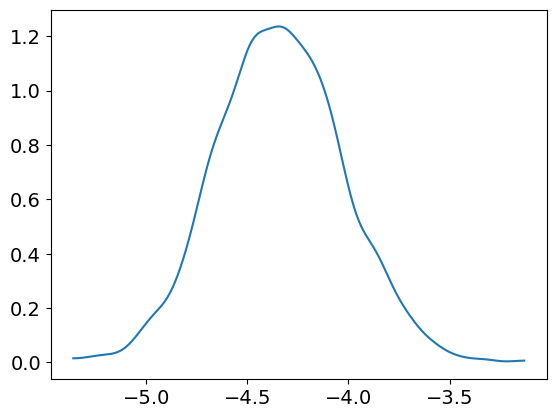

In [169]:
h=8   #plot the posterior of betas seen in cluster h

az.plot_dist(values=fit_clus_az.posterior.betas_clus.values[0:,0:,0,h])